In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import datetime
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from gensim.models import Word2Vec

## Data Read and Cleanup

In [2]:
# Load the data from .sqlite file

db=sqlite3.connect('../input/database.sqlite')

# select all reviews from given dataset
# we are considering a review is positive or negative on the basis of the Score column which is nothing but a rating given
# by a customer for a product. If a score >3 it is considered as positive elseif score<3 it is negative and score=3 is neutral
# Therefore all reviews which are having score other than 3 are taken into account.

filtered_data=pd.read_sql_query("""
SELECT *
FROM Reviews WHERE Score!=3""",db)

# Replace this numbers in Score column as per our assumptions i.e replace 3+ with positive 1 and 3- with negative 0
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be positive (1) and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)


(525814, 10)


In [3]:
# converting datestamp into string representable form as YYYY-MM-DD
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d'))

In [4]:
# There is lot of duplicate data present as we can see above productId B007OSBE1U 
# have multiple duplicate reviews this is what we need to avoid.

# so first step is to sort the data and then remove duplicate entries so that only
# one copy of them should be remain in our data.
dup_free=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})
# dup_free.head()
# This is shape of our dataset of 100k datapoints after removal of dups
dup_free.shape

(364173, 10)

In [5]:
final_filtered_data=dup_free[dup_free.HelpfulnessNumerator<=dup_free.HelpfulnessDenominator]

In [6]:
final_filtered_data.shape

(364171, 10)

In [7]:
((final_filtered_data['Id'].size*1.0)/(filtered_data['Id'].size*(1.0)))*100

69.25852107399194

#### so after data cleanup we left with 69.25% data of 525k datapoints

In [8]:
# reference:https://www.geeksforgeeks.org/python-pandas-dataframe-sample/
#As randomly select data, in order that our dataset remain balanced
positive_rev = final_filtered_data[final_filtered_data.Score ==1]
positive_rev = positive_rev.sample(frac=0.11,random_state=1)
print(len(positive_rev))

negative_rev = final_filtered_data[final_filtered_data.Score == 0]
negative_rev = negative_rev.sample(frac=0.54,random_state=1)
print(len(negative_rev))

final = pd.concat([positive_rev,negative_rev],axis=0)
#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final=final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

33777
30839


In [9]:
print("Proportion of positive reviews :",len(positive_rev)/len(final))
print("Proportion of negative reviews :",len(negative_rev)/len(final))

Proportion of positive reviews : 0.5227343072923115
Proportion of negative reviews : 0.4772656927076885


### Dataset seems balanced now with 52% positive reviews and 48% negative reviews

## Text Preprocessing 

In [10]:
# Now we have already done with data cleanup part. As in our dataset most cruicial or I can say most determinant feature
# from which we can say it is positive or negative review is review Text.
# So we are need to perform some Text Preprocessing on it before we actually convert it into word vector or vectorization

# I am creating some precompiled objects for our regular expressions cause it will be used for over ~64K times (in our case)
# as it seems fast but using regular expression is CPU expensive task so it would be faster to use precompiled search objects.

_wont  = re.compile(r"won't")
_cant  = re.compile(r"can\'t")
_not   = re.compile(r"n\'t")
_are   = re.compile(r"\'re")
_is    = re.compile(r"\'s")
_would = re.compile(r"\'d")
_will  = re.compile(r"\'ll")
_have  = re.compile(r"\'ve")
_am    = re.compile(r"\'m")

# we are ignoring "not" from stopwords as "not" plays important role for semantic analysis as it can alone change the 
# meaning of whole sentence
stopWords = set(stopwords.words('english'))
sw=stopWords.copy()
sw.discard('not')

def expand_abbrevated_words(phrase):
    phrase = re.sub(_wont, "will not", phrase)
    phrase = re.sub(_cant, "can not", phrase)
    phrase = re.sub(_not, " not", phrase)
    phrase = re.sub(_are, " are", phrase)
    phrase = re.sub(_is, " is", phrase)
    phrase = re.sub(_would, " would", phrase)
    phrase = re.sub(_will, " will", phrase)
    phrase = re.sub(_have, " have", phrase)
    phrase = re.sub(_am, " am", phrase)
    return phrase

# As this dataset is web scrapped from amazon.com while scrapping there might be a good chance that we are getting some garbage
# characters/words/sentences in our Text data like html tags,links, alphanumeric characters so we ought to remove them
def remove_unwanted_char(data):    
    processed_data=[]
    for sentence in tqdm(data):
        sentence = re.sub(r"http\S+", "", sentence) # this will remove links
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = re.sub("\S*\d\S*", "", sentence).strip() #remove alphanumeric words
        sentence = re.sub('[^A-Za-z]+', ' ', sentence) #remove special characters
        sentence =  expand_abbrevated_words(sentence)
        # we need to convert everything into lower case because I dont want my model to treat same word differently
        # if it appears in the begining of sentence and somewhere middle of sentence.
        # Also remove stopword froms from sentences
        sentence =" ".join(j.lower() for j in sentence.split() if j.lower() not in sw)
        processed_data.append(sentence)
    return processed_data
 
def preprocess_my_data(data):
    return remove_unwanted_char(data)
        

In [11]:
data_to_be_processed=final['Text'].values
processed_data=preprocess_my_data(data_to_be_processed)
label=final['Score']
print(len(processed_data))

100%|██████████| 64616/64616 [00:22<00:00, 2861.86it/s]

64616


In [12]:
final['CleanedText']=processed_data
print(processed_data[0])

one movie movie collection filled comedy action whatever else want call


## Stemming

In [13]:
# Before applying BoW or Tfidf featurization techinque on our corpus we need to apply stemmming for each word in each document.
stemmed_data=processed_data.copy()
bow_stem=SnowballStemmer('english')
stemmed_reviews=[]
def stemSentence(review):
    token_words=word_tokenize(review)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(bow_stem.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

for review in tqdm(stemmed_data):
    rev=stemSentence(review)
    stemmed_reviews.append(rev)

100%|██████████| 64616/64616 [00:59<00:00, 1092.29it/s]


## Splitting Data In Train ,CV and Test Dataset

In [14]:
# To avoid data leakage we are splitting our dataset before any featurization.
x_tr, x_test, y_tr, y_test = train_test_split(stemmed_reviews, label, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
x_tr, x_cv, y_tr, y_cv = train_test_split(x_tr, y_tr, test_size=0.3,random_state=0)

print("Sizes of Train,test and cv dataset after split: {0} , {1}, {2}".format(len(x_tr),len(x_test),len(x_cv)))

Sizes of Train,test and cv dataset after split: 31661 , 19385, 13570


## 1. BoW (Bag of Words)

In [15]:
# Applying fit_transform to only train dataset as we are only because we want our vocabulary to be built only on train data
bow_count=CountVectorizer(min_df=10, max_features=300)
bow_fit=bow_count.fit(x_tr)
print("Some Feature names: ",bow_fit.get_feature_names()[:5])

#extract token count out of raw text document using vocab build using train dataset
bow_train=bow_count.transform(x_tr)
bow_cv=bow_count.transform(x_cv)
bow_test=bow_count.transform(x_test)

print("Shape of transformed train text reviews",bow_train.shape)
print("Shape of transformed cv text reviews",bow_cv.shape)
print("Shape of transformed test text reviews",bow_test.shape)


Some Feature names:  ['abl', 'absolut', 'actual', 'ad', 'add']
Shape of transformed train text reviews (31661, 300)
Shape of transformed cv text reviews (13570, 300)
Shape of transformed test text reviews (19385, 300)


In [16]:
# converting sparse matrix to dense matrix before doing standardization 
bow_dense_train_reviews=bow_train.toarray()
bow_dense_cv_reviews=bow_cv.toarray()
bow_dense_test_reviews=bow_test.toarray()


In [17]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(bow_dense_train_reviews*1.0)
std_cv_data=std_data.transform(bow_dense_cv_reviews*1.0)
std_test_data=std_data.transform(bow_dense_test_reviews*1.0)


## HyperParameter Tuning Using Simple Cross-Validation

In [18]:

def find_best_k(train_data,tr_label,cv_data,cv_label,algo):
   # Compute ROC curve and ROC area for each class
    train_auc=[]
    cv_auc=[]
    roc_auc = dict()
    K = [1, 5, 10, 15, 21, 31, 41, 51,71,91]
    for i in tqdm(K):
        knn = KNeighborsClassifier(n_neighbors=i,algorithm=algo)
        
        # fitting the model on crossvalidation train
        knn.fit(train_data, tr_label)
        y_cv_pred    =  knn.predict_proba(cv_data)[:,1]
        y_tr_pred    =  knn.predict_proba(train_data)[:,1]
        cv_auc.append(roc_auc_score(cv_label, y_cv_pred))
        train_auc.append(roc_auc_score(tr_label,y_tr_pred))
    
    train_error=[1- x for x in train_auc]
    cv_error=[1- x for x in cv_auc]
    plt.plot(K, cv_error, 'bo',linestyle="solid",label='CV AUC')
    plt.plot(K, train_error, 'yo',linestyle="solid",label='TRAIN AUC')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("Error")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()
    return

In [19]:
def plot_roc_auc(labels,predictions,title):
    fpr,tpr, _  = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {} dataset'.format(title))
    plt.legend(loc="lower right")

def testing_on_test_data(train_rev,train_label,test_rev,test_label,algo,best_k):
    plt.figure(1,figsize=(15,7))
    knn = KNeighborsClassifier(n_neighbors=best_k,algorithm=algo)        
    # fitting the model on crossvalidation train
    knn.fit(train_rev, train_label)
    y_test_pred = knn.predict_proba(test_rev)[:,1]
    y_train_pred= knn.predict_proba(train_rev)[:,1]
    
    plt.subplot(121)    
    plot_roc_auc(train_label,y_train_pred,"Train")
    
    plt.subplot(122)    
    plot_roc_auc(test_label,y_test_pred,"Test")

    plt.show()

In [20]:
def get_confusion_matrix(train_rev,train_label,test_rev,test_label,algo,best_k):
    plt.figure(1,figsize=(15,7))
    np.set_printoptions(precision=5)
    knn=KNeighborsClassifier(n_neighbors=best_k,algorithm=algo)
    knn.fit(train_rev,train_label)
    train_pred=knn.predict(train_rev)
    test_pred=knn.predict(test_rev)

    test_cnf_matrix=confusion_matrix(test_label,test_pred)
    train_cnf_matrix=confusion_matrix(train_label,train_pred)
    
    plt.subplot(121)
    sns.heatmap(test_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TestSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    
    plt.subplot(122)
    sns.heatmap(train_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TrainSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    plt.show()

### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [10:20<00:00, 63.32s/it]


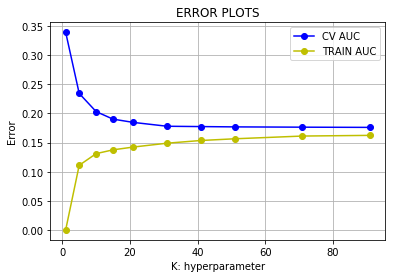

In [21]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"brute")

### from above graph,from the error plot we need to choose K such that Training Error and CV Error both are balanced i.e the value of K for whom both curves are nearer to each other.Here we are choosing K=21 so that in real world result of classification will be interpretable.

### Testing with Test Data

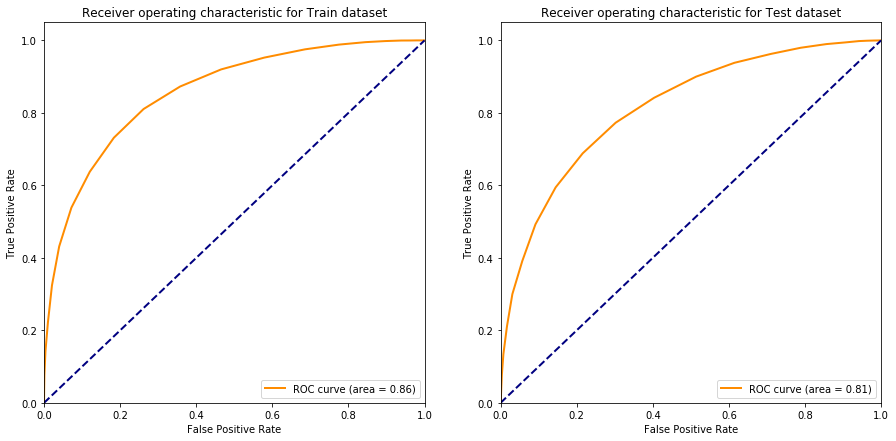

In [22]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=21)

### Confusion Matrix

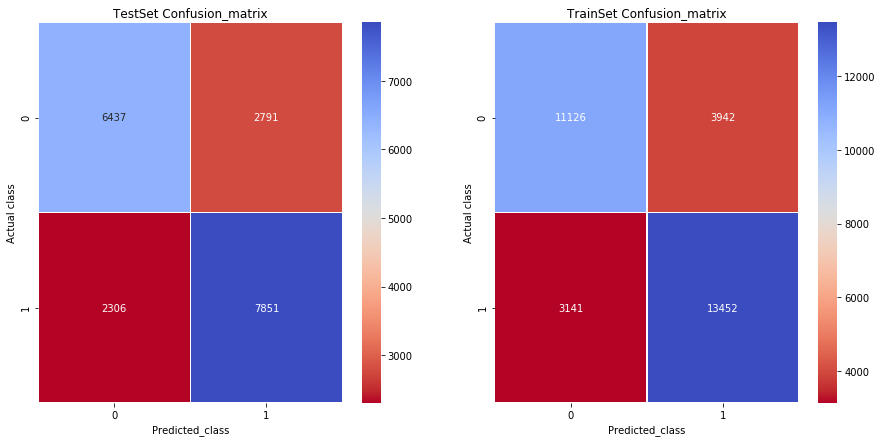

In [23]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=21)

## 2. TFIDF 

In [24]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=300)
tfidf_tr=tfidf_count.fit_transform(x_tr)
tfidf_cv=tfidf_count.transform(x_cv)
tfidf_test=tfidf_count.transform(x_test)
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of cv review text    :",tfidf_cv.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)


Shape of tfidf vector representation of train review text : (31661, 300)
Shape of tfidf vector representation of cv review text    : (13570, 300)
Shape of tfidf vector representation of test review text  : (19385, 300)


In [25]:
# converting sparse matrix to dense matrix before doing standardization 
tfidf_dense_train_reviews=tfidf_tr.toarray()
tfidf_dense_cv_reviews=tfidf_cv.toarray()
tfidf_dense_test_reviews=tfidf_test.toarray()


In [26]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(tfidf_dense_train_reviews*1.0)
std_cv_data=std_data.transform(tfidf_dense_cv_reviews*1.0)
std_test_data=std_data.transform(tfidf_dense_test_reviews*1.0)


### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [10:16<00:00, 62.88s/it]


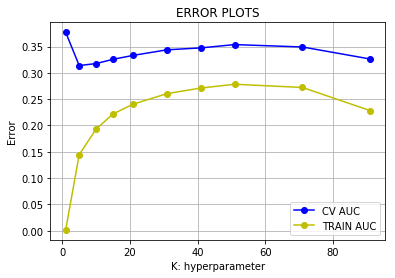

In [27]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"brute")

### Here train and cv error values are low at at K=5

### Testing with Test Data

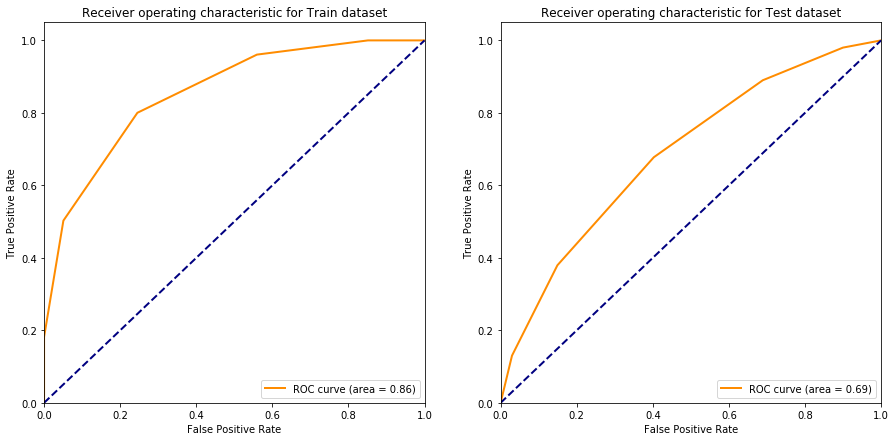

In [28]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=5)

### Confusion Matrix

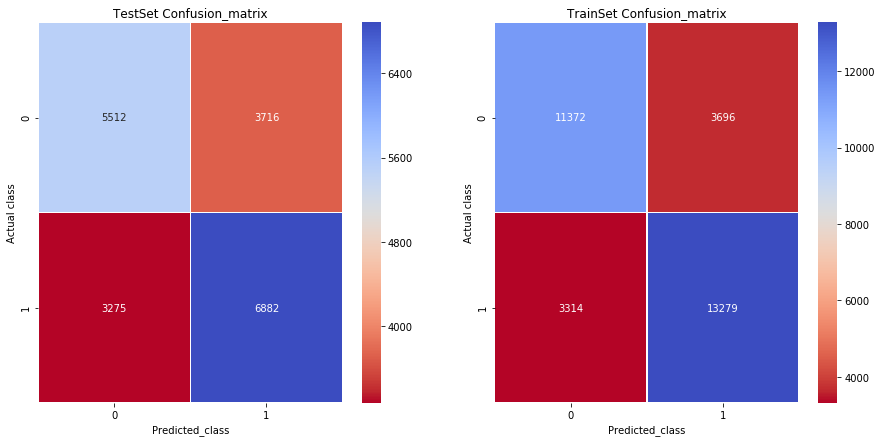

In [29]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=5)

## 3. Avg Word2Vec

In [30]:
# As w2vec preserves semantic meaning of words I am not going to do stemming for this.
# split each sentence from train dataset into words
reviews=x_tr.copy()
train_sentences_set=[]
for s in reviews:
    train_sentences_set.append(s.split())

In [31]:
# min_count = 10 considers only words that occured atleast 10 times
# size = dimensionality of word vectors
# workers = no of threads to use while training our w2v model/featurization
w2v_model=Word2Vec(train_sentences_set,min_count=10,size=300, workers=4)

In [32]:
w2v_words = list(w2v_model.wv.vocab)

In [33]:
def compute_avgW2Vec(reviews):
    # average Word2Vec
    # compute average word2vec for each review.
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())
        
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(rev_words): # for each review/sentence
        sent_vec = np.zeros(300) # as our w2v model is trained with size=50 i.e 50 dimension so this value will be change as dim change
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    
    return sent_vectors #Average W2v repersentation of reviews in given dataset


In [34]:
train_avgw2v=compute_avgW2Vec(x_tr) 

100%|██████████| 31661/31661 [00:32<00:00, 961.30it/s] 


In [35]:
cv_avgw2v=compute_avgW2Vec(x_cv) 

100%|██████████| 13570/13570 [00:13<00:00, 1007.03it/s]


In [36]:
test_avgw2v=compute_avgW2Vec(x_test) 

100%|██████████| 19385/19385 [00:19<00:00, 995.62it/s] 


In [37]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(train_avgw2v)
std_cv_data=std_data.transform(cv_avgw2v)
std_test_data=std_data.transform(test_avgw2v)

### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [09:53<00:00, 60.21s/it]


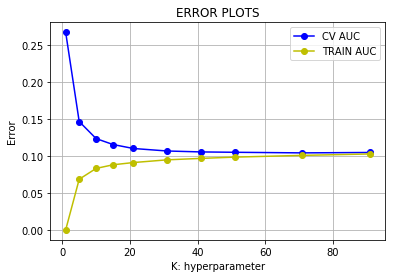

In [38]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"brute")

### Testing with Test Data

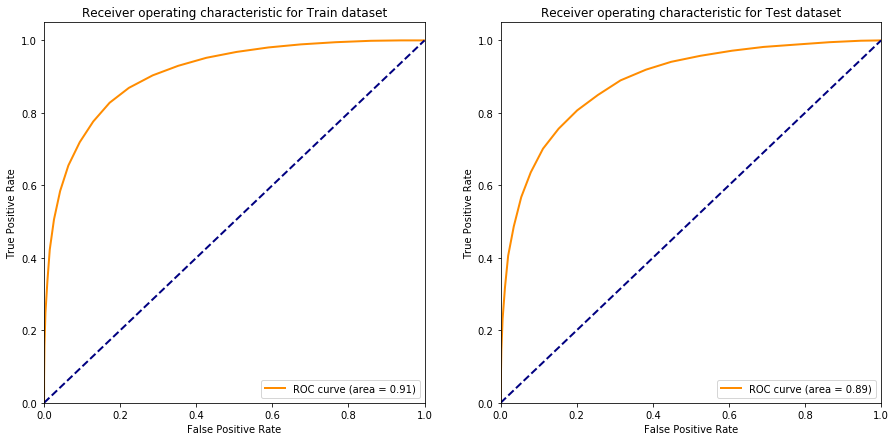

In [39]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=21)

### Confusion Matrix

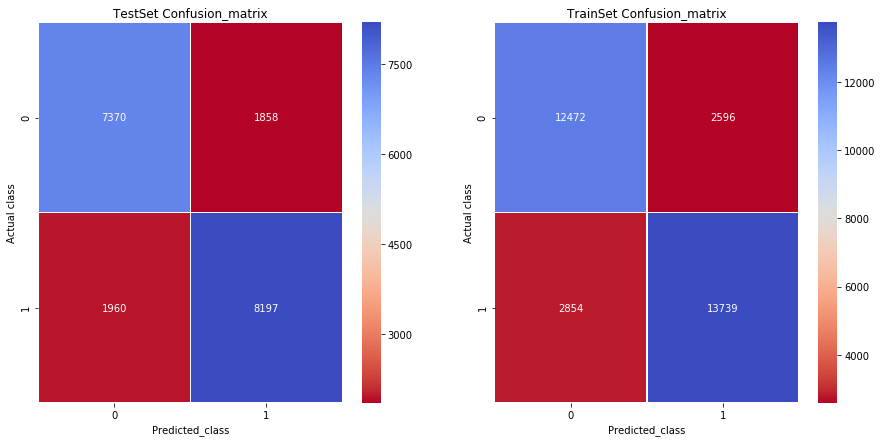

In [40]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=21)

## 4. TFIDF weighted W2Vec

In [41]:
tfidf_w2v = TfidfVectorizer(min_df=10,max_features=300)
tfidf_w2v.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_w2v.get_feature_names(), list(tfidf_w2v.idf_)))
tfidf_feat = tfidf_w2v.get_feature_names() # tfidf words/col-names

In [42]:
def compute_tfidf_w2vec(reviews):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())
        
    for sent in tqdm(rev_words): # for each review/sentence 
        sent_vec = np.zeros(300) #as our w2v model is trained with size=50 i.e 500 dimension so this value will be change as dim change
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf values of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    
    return tfidf_sent_vectors

In [43]:
train_tfidf_w2v=compute_tfidf_w2vec(x_tr) 

100%|██████████| 31661/31661 [00:49<00:00, 638.57it/s]


In [44]:
cv_tfidf_w2v=compute_tfidf_w2vec(x_cv) 

100%|██████████| 13570/13570 [00:22<00:00, 614.33it/s]


In [45]:
test_tfidf_w2v=compute_tfidf_w2vec(x_test) 

100%|██████████| 19385/19385 [00:30<00:00, 629.01it/s]


In [46]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(train_tfidf_w2v)
std_cv_data=std_data.transform(cv_tfidf_w2v)
std_test_data=std_data.transform(test_tfidf_w2v)

### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [09:27<00:00, 57.59s/it]


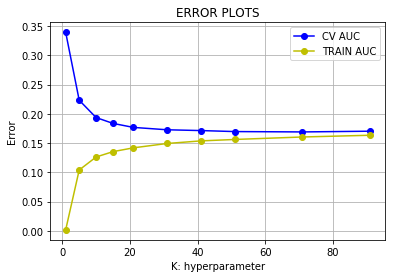

In [47]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"brute")

### Testing with Test Data

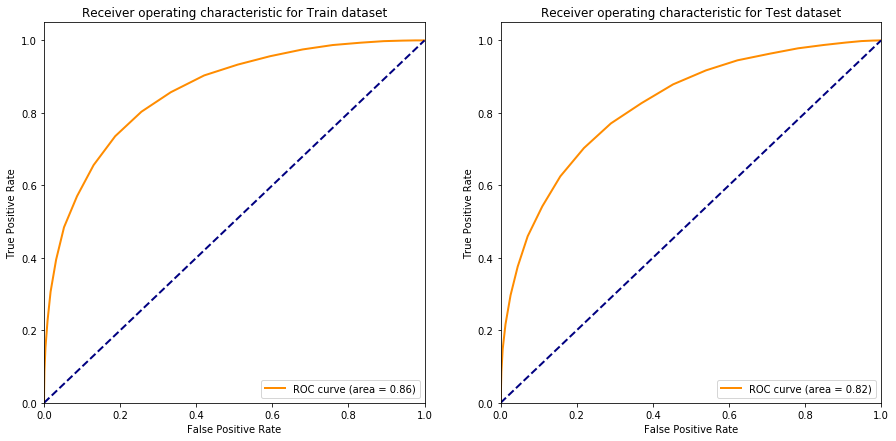

In [48]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=21)

### Confusion Matrix

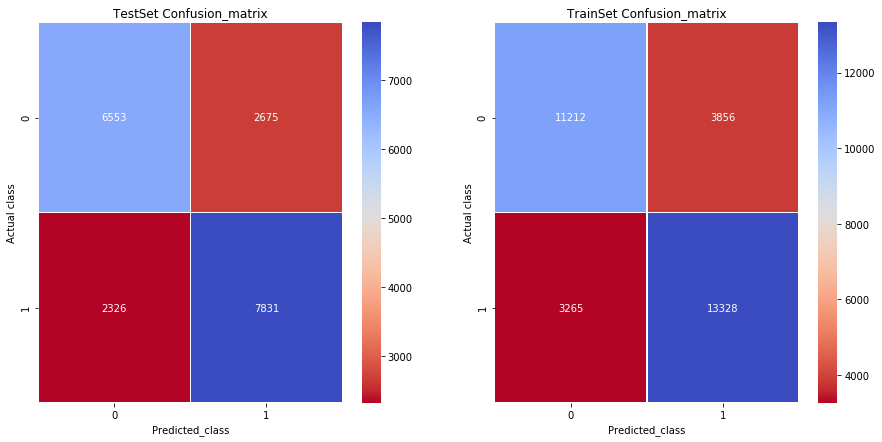

In [49]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"brute",best_k=21)

## 1.BoW (Kd-tree)

In [21]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(bow_dense_train_reviews*1.0)
std_cv_data=std_data.transform(bow_dense_cv_reviews*1.0)
std_test_data=std_data.transform(bow_dense_test_reviews*1.0)

### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [2:53:47<00:00, 1068.00s/it] 


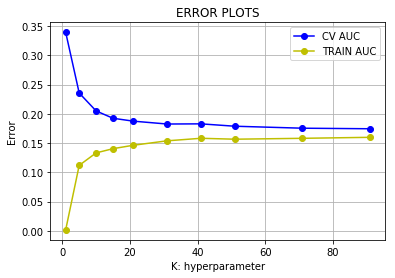

In [22]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"kd_tree")

### Testing with Test Data

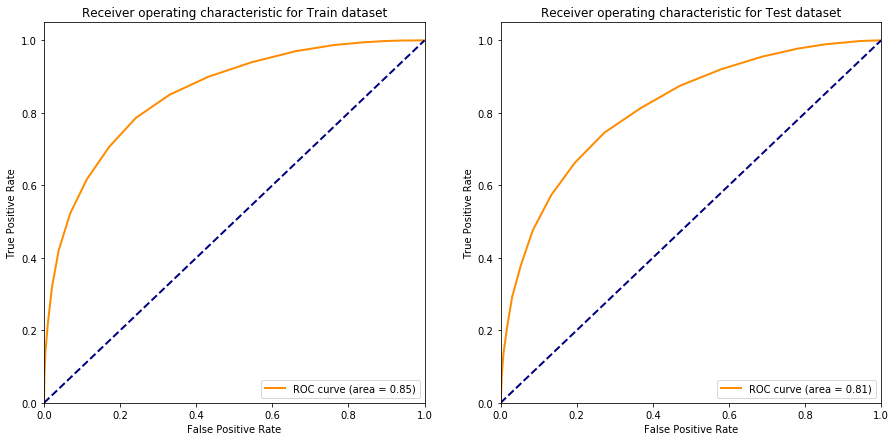

In [23]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=21)

### Confusion Matrix

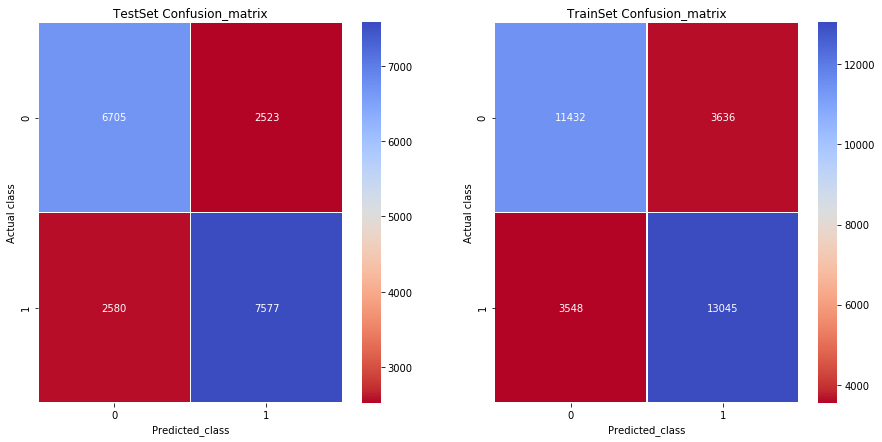

In [24]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=21)

### 2. Tfidf (Kd-tree)

In [21]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(tfidf_dense_train_reviews*1.0)
std_cv_data=std_data.transform(tfidf_dense_cv_reviews*1.0)
std_test_data=std_data.transform(tfidf_dense_test_reviews*1.0)

### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [3:06:51<00:00, 1156.53s/it] 


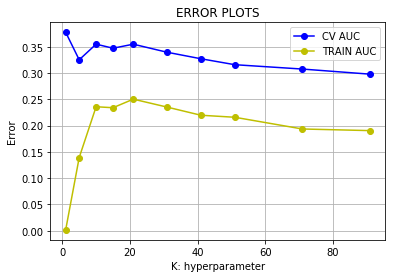

In [22]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"kd_tree")

### Testing with Test Data

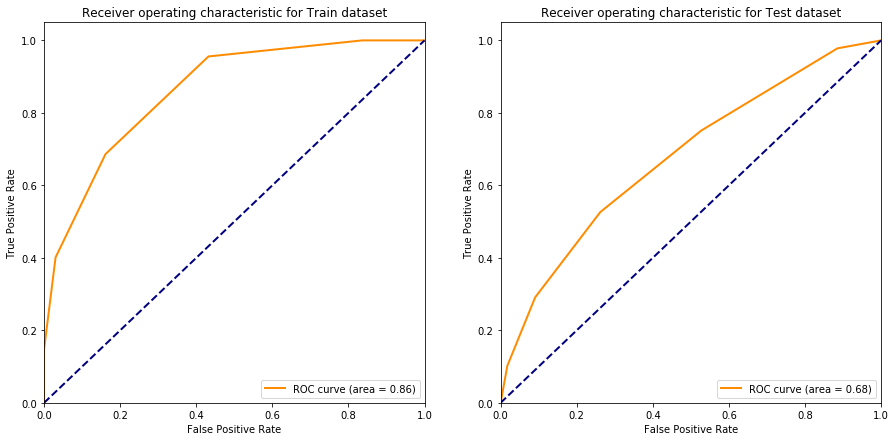

In [24]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=5)

### Confusion Matrix

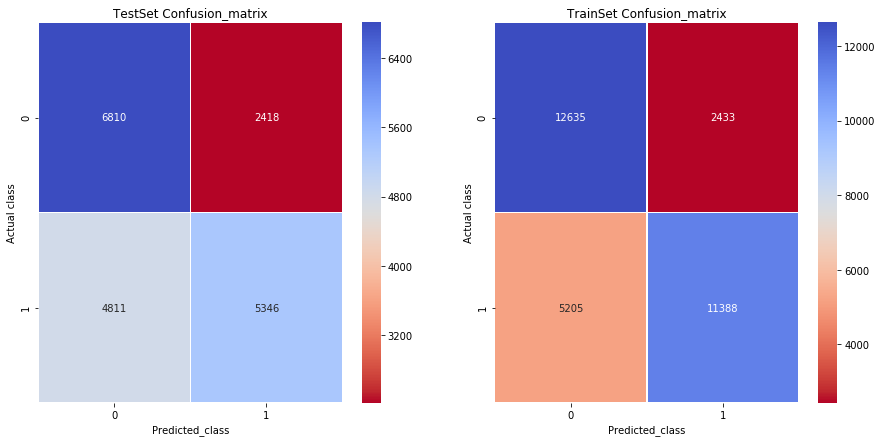

In [25]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=5)

## 3. Avg Word2Vec (kd-tree)

In [26]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(train_avgw2v)
std_cv_data=std_data.transform(cv_avgw2v)
std_test_data=std_data.transform(test_avgw2v)

### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [3:31:44<00:00, 1328.08s/it] 


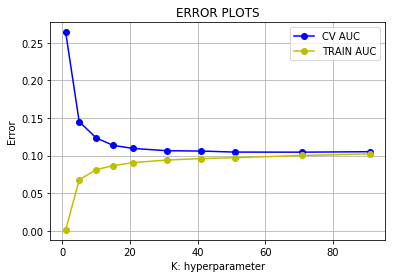

In [27]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"kd_tree")

### Testing with Test Data

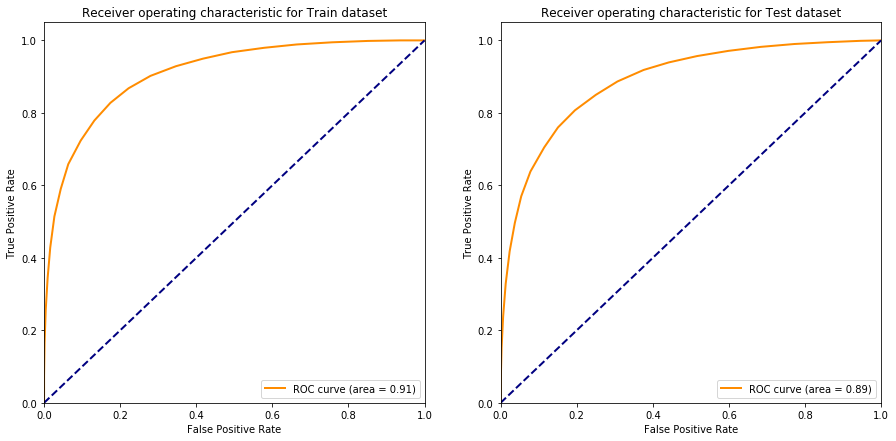

In [30]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=21)

### Confusion Matrix

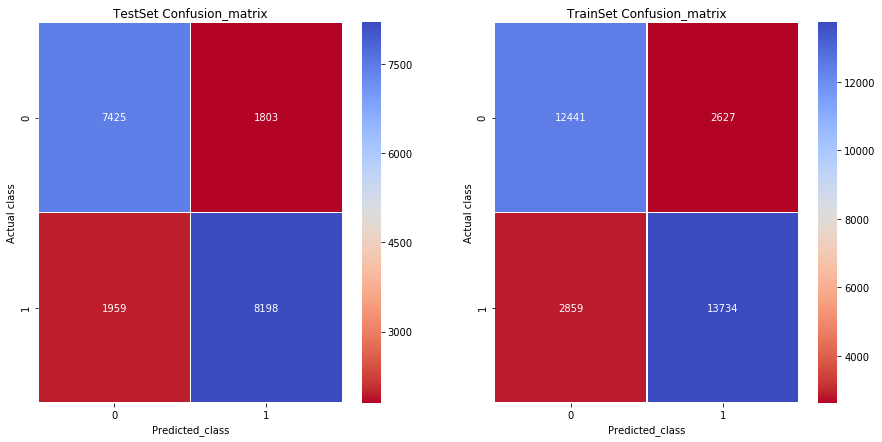

In [31]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=21)

## 4. TFIDF weighted W2Vec (kd-tree)

In [30]:
# Apply standardization on train,test and cv dataset
std_data=StandardScaler()

std_train_data=std_data.fit_transform(train_tfidf_w2v)
std_cv_data=std_data.transform(cv_tfidf_w2v)
std_test_data=std_data.transform(test_tfidf_w2v)

### Finding Best K by observing Train Vs CV Error Plot

100%|██████████| 10/10 [2:18:15<00:00, 921.06s/it]


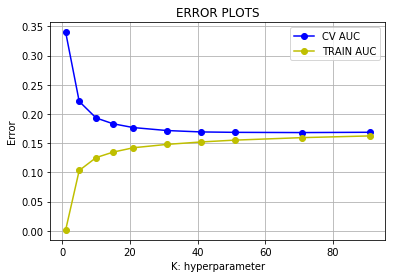

In [31]:
find_best_k(std_train_data,y_tr,std_cv_data,y_cv,"kd_tree")

### Testing with Test Data

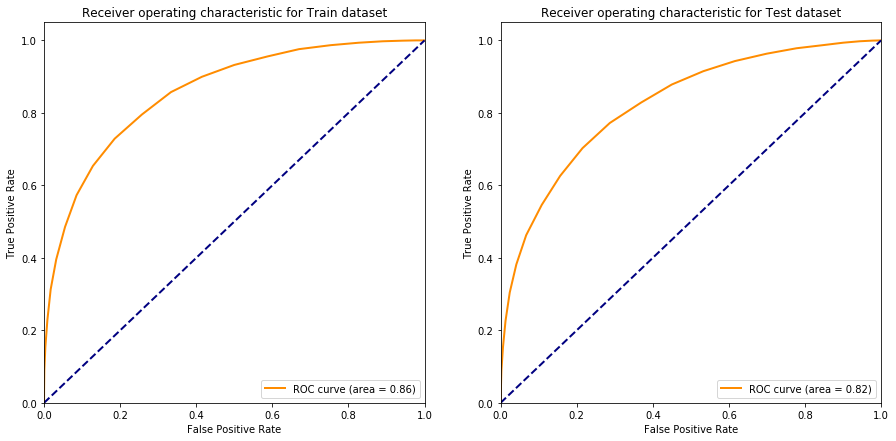

In [32]:
testing_on_test_data(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=21)

### Confusion Matrix

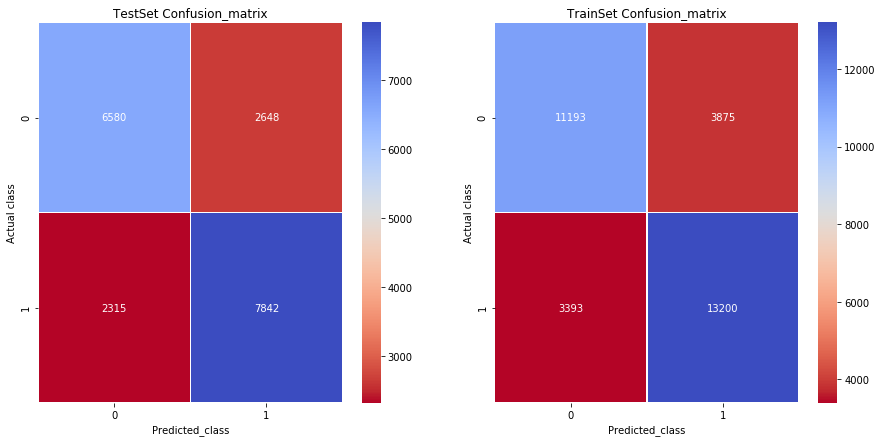

In [33]:
get_confusion_matrix(std_train_data,y_tr,std_test_data,y_test,"kd_tree",best_k=21)

## Summary

In [3]:
print("""
          |  Vectorizer    |   Model   |   HyperParameter  |  AUC      |
          ______________________________________________________________

              BoW          |    Brute  |         21        |      0.81 |
             tfidf         |    Brute  |          5        |      0.69 |
            Avg tfidf      |    Brute  |         21        |      0.89 |
        tfidf Weighted W2v |    Brute  |         21        |      0.82 |
        
             BoW           |   kd-tree |         21        |      0.81 |
            tfidf          |   kd-tree |          5        |      0.68 |
           Avg tfidf       |   kd-tree |         21        |      0.89 |
        tfidf Weighted W2v |   kd-tree |         21        |      0.82 |""")


          |  Vectorizer    |   Model   |   HyperParameter  |  AUC      |
          ______________________________________________________________

              BoW          |    Brute  |         21        |      0.81 |
             tfidf         |    Brute  |          5        |      0.69 |
            Avg tfidf      |    Brute  |         21        |      0.89 |
        tfidf Weighted W2v |    Brute  |         21        |      0.82 |
        
             BoW           |   kd-tree |         21        |      0.81 |
            tfidf          |   kd-tree |          5        |      0.68 |
           Avg tfidf       |   kd-tree |         21        |      0.89 |
        tfidf Weighted W2v |   kd-tree |         21        |      0.82 |


### Conclusion:

1. KNN is Classification algorithm, depending upon K majority neighbors we decide the class lable for a given query point.

2. Here we are using KNN for deciding/classify reviews as positive or negative.

3. One of the basic variant of KNN is "brute force", in this distance of each point from our query point is measured and we decide our class lable from majority points among  only K smallest distant neighbors,but time complexity of these is very high.

4. So to get over this we have another methods known as kd-tree and LSH

5. Kd-tree is based on BST algorithm.

6. As we are taking 33k positive and 30k negative reviews from our whole corpus our dataset is pretty balanced.So we are concerning about only AUC value to decide optimal K.

7. Our data varies on time so we used Time Based Splitting to Train,CV and Test dataset,in order to test our models performance on future unseen data.

8. Obeserving Train Error vs CV Error curve we choose K where we have both curves nearer to each other that is error value should be balanced in Train Set and CV Set.

9. ROCAUC value for Random Classifier is 0.5 and our models getting values greter than 0.5 so we can say our models are good classifiers.